In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Robot leg configuration
upper_leg_length = 10.0
lower_leg_length = 10.0

body_length = 21.0
body_width = 15.8
max_height = 15.0

# Shoulder positions (static)
shoulder_positions = np.asfortranarray([
    [body_length / 2, body_length / 2, -body_length / 2, -body_length / 2],
    [-body_width / 2, body_width / 2, -body_width / 2, body_width / 2],
    [0, 0, 0, 0],
])



In [2]:

def inverse_kinematics(x: float, y: float, z: float, a1: float=upper_leg_length, a2: float=lower_leg_length):
    y_prime = -math.sqrt((z)**2 + y**2)
    thetaz = math.atan2(abs(y), z)

    c2 = (x**2 + y_prime**2 - a1**2 - a2**2) / (2 * a1 * a2)
    s2 = math.sqrt(abs(1 - c2**2))
    theta2 = math.atan2(s2, c2)

    c1 = (x * (a1 + (a2 * c2)) + y_prime * (a2 * s2)) / (x**2 + y_prime**2)
    s1 = (y_prime * (a1 + (a2 * c2)) - x * (a2 * s2)) / (x**2 + y_prime**2)
    theta1 = math.atan2(s1, c1)

    theta_shoulder = -theta1
    theta_elbow = theta_shoulder - theta2
    theta_hip = thetaz

    return math.degrees(theta_shoulder), math.degrees(theta_elbow), math.degrees(theta_hip)


In [3]:

def compensate_foot_positions_by_gyro(np_foot_positions, roll, pitch):
    roll_rad = math.radians(roll)
    pitch_rad = math.radians(pitch)
    body_normal = np.array([
        math.sin(roll_rad),
        -math.sin(pitch_rad) * math.cos(roll_rad),
        math.cos(pitch_rad) * math.cos(roll_rad)
    ])

    base_correction = 0.8
    severity = max(
        min(abs(roll) / 45.0, 1.0),
        min(abs(pitch) / 45.0, 1.0)
    )
    correction_factor = base_correction * (1.0 + severity)

    max_compensation = 3.0
    max_leg_extension_y = -max_height * 1.2
    min_leg_extension_y = -max_height * 0.5

    compensated_positions = np_foot_positions.copy()
    for i in range(4):
        dx = shoulder_positions[0, i]
        dy = shoulder_positions[1, i]
        height_adj = (dx * body_normal[0] + dy * body_normal[1]) * correction_factor
        height_adj = np.clip(height_adj, -max_compensation, max_compensation)

        new_height = compensated_positions[2, i] - height_adj
        if new_height < max_leg_extension_y:
            height_adj = compensated_positions[2, i] - max_leg_extension_y
        elif new_height > min_leg_extension_y:
            height_adj = compensated_positions[2, i] - min_leg_extension_y

        compensated_positions[2, i] -= height_adj

    return compensated_positions


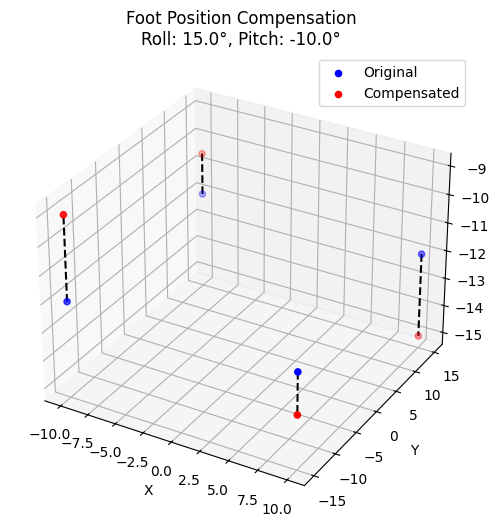

In [4]:

# Synthetic flat stance
original_positions = np.array([
    [ 10.0,  10.0, -10.0, -10.0],  # x
    [-15.0,  15.0, -15.0,  15.0],  # y
    [-12.0, -12.0, -12.0, -12.0]   # z
])

# Simulate gyro data
roll_angle = 15.0
pitch_angle = -10.0

compensated = compensate_foot_positions_by_gyro(original_positions, roll=roll_angle, pitch=pitch_angle)

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*original_positions, color='blue', label='Original')
ax.scatter(*compensated, color='red', label='Compensated')

for i in range(4):
    ax.plot([original_positions[0, i], compensated[0, i]],
            [original_positions[1, i], compensated[1, i]],
            [original_positions[2, i], compensated[2, i]], 'k--')

ax.set_title(f"Foot Position Compensation\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.show()


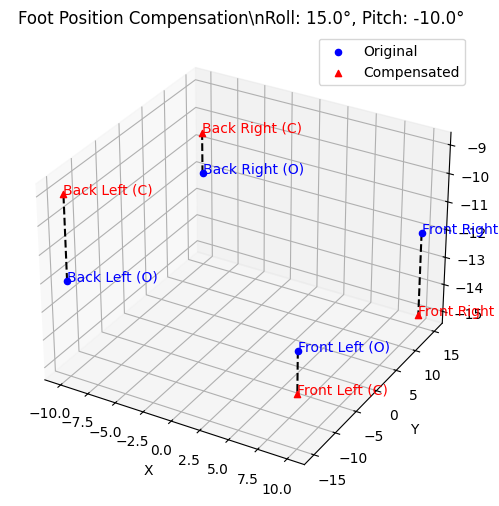

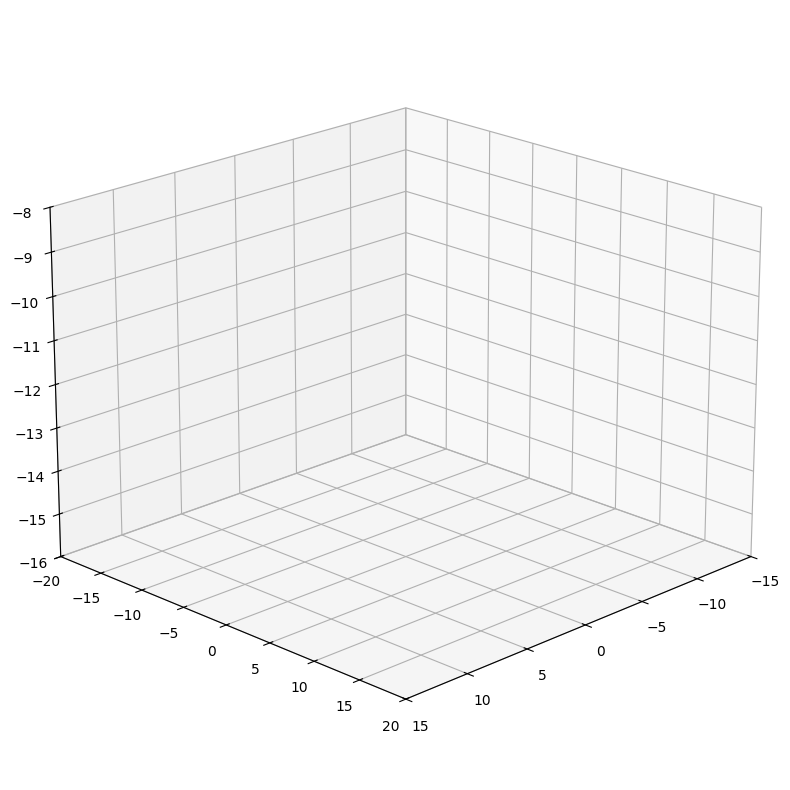

In [8]:
# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Colors for each leg
colors = ['blue', 'green', 'purple', 'orange']
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']

# Plot each leg's original and compensated point
for i in range(4):
    ax.scatter(original_positions[0, i], original_positions[1, i], original_positions[2, i],
               color='blue', label='Original' if i == 0 else "", marker='o')
    ax.scatter(compensated[0, i], compensated[1, i], compensated[2, i],
               color='red', label='Compensated' if i == 0 else "", marker='^')

    # Connect with dashed line
    ax.plot([original_positions[0, i], compensated[0, i]],
            [original_positions[1, i], compensated[1, i]],
            [original_positions[2, i], compensated[2, i]],
            'k--')

    # Add labels
    ax.text(original_positions[0, i], original_positions[1, i], original_positions[2, i],
            f"{labels[i]} (O)", color='blue')
    ax.text(compensated[0, i], compensated[1, i], compensated[2, i],
            f"{labels[i]} (C)", color='red')

ax.set_title(f"Foot Position Compensation\\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-15, 15)
ax.set_ylim(-20, 20)
ax.set_zlim(-16, -8)
ax.view_init(elev=20, azim=45)
ax.grid(True)
plt.tight_layout()
plt.show()

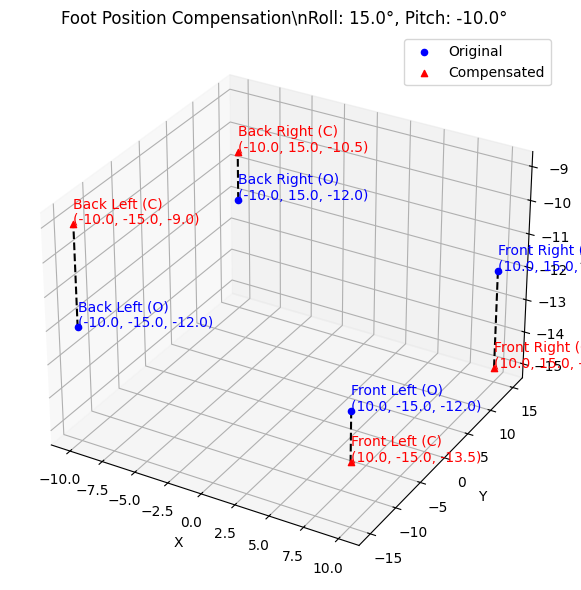

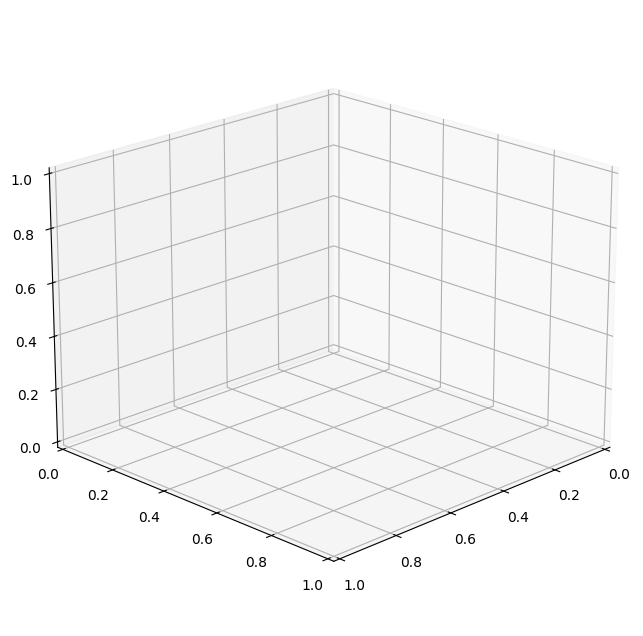

In [18]:
# Plotting
fig = plt.figure(figsize=(20, 6))
ax.view_init(elev=40, azim=1)  # Adjust elevation and azimuth
ax = fig.add_subplot(111, projection='3d')

# Colors for each leg
colors = ['blue', 'green', 'purple', 'orange']
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']

# Plot each leg's original and compensated point
for i in range(4):
    # Original point
    ox, oy, oz = original_positions[:, i]
    ax.scatter(ox, oy, oz, color='blue', label='Original' if i == 0 else "", marker='o')
    ax.text(ox, oy, oz, f"{labels[i]} (O)\n({ox:.1f}, {oy:.1f}, {oz:.1f})", color='blue')

    # Compensated point
    cx, cy, cz = compensated[:, i]
    ax.scatter(cx, cy, cz, color='red', label='Compensated' if i == 0 else "", marker='^')
    ax.text(cx, cy, cz, f"{labels[i]} (C)\n({cx:.1f}, {cy:.1f}, {cz:.1f})", color='red')

    # Dashed line between original and compensated
    ax.plot([ox, cx], [oy, cy], [oz, cz], 'k--')

# Labels and settings
ax.set_title(f"Foot Position Compensation\\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.tight_layout()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=45)
plt.show()

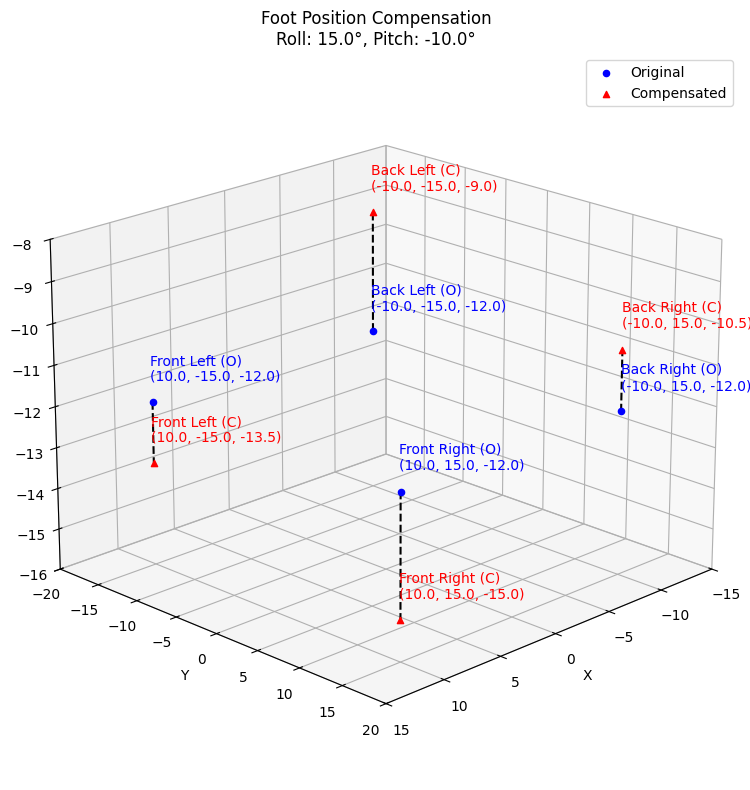

In [19]:
# === Apply gyro compensation ===
roll_angle = 15.0
pitch_angle = -10.0
compensated = compensate_foot_positions_by_gyro(original_positions, roll=roll_angle, pitch=pitch_angle)

# === Plotting ===
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set custom axis limits and view angle
ax.set_xlim(-15, 15)
ax.set_ylim(-20, 20)
ax.set_zlim(-16, -8)
ax.view_init(elev=20, azim=45)

# Leg labels
labels = ['Front Left', 'Front Right', 'Back Left', 'Back Right']
offset = 0.6

# Plot all four legs
for i in range(4):
    ox, oy, oz = original_positions[:, i]
    cx, cy, cz = compensated[:, i]

    # Plot original and compensated points
    ax.scatter(ox, oy, oz, color='blue', marker='o', label='Original' if i == 0 else "")
    ax.scatter(cx, cy, cz, color='red', marker='^', label='Compensated' if i == 0 else "")

    # Connect with a dashed line
    ax.plot([ox, cx], [oy, cy], [oz, cz], 'k--')

    # Label with coordinates
    ax.text(ox + offset, oy + offset, oz + offset, f"{labels[i]} (O)\n({ox:.1f}, {oy:.1f}, {oz:.1f})", color='blue')
    ax.text(cx + offset, cy + offset, cz + offset, f"{labels[i]} (C)\n({cx:.1f}, {cy:.1f}, {cz:.1f})", color='red')

# Final decorations
ax.set_title(f"Foot Position Compensation\nRoll: {roll_angle}°, Pitch: {pitch_angle}°")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [21]:
def polygon_area_3d(points: np.ndarray) -> float:
    """
    Calculate the area of a polygon in 3D space using vector cross products.
    Assumes the points form a simple, non-intersecting polygon in order.
    points: np.ndarray of shape (N, 3) - list of 3D vertices in order
    """
    if points.shape[0] < 3:
        return 0.0

    # Choose the first point as reference
    ref = points[0]
    area = 0.0
    for i in range(1, len(points) - 1):
        v1 = points[i] - ref
        v2 = points[i + 1] - ref
        cross_prod = np.cross(v1, v2)
        triangle_area = 0.5 * np.linalg.norm(cross_prod)
        area += triangle_area
    return area


# 4 points forming a tilted rectangle
foot_points = np.array([
    [ 10.0, -15.0, -13.5],  # Front Left
    [ 10.0,  15.0, -15.0],  # Front Right
    [-10.0, -15.0,  -9.0],  # Back Left
    [-10.0,  15.0, -10.5],  # Back Right
])

area = polygon_area_3d(foot_points)
print(f"3D polygon area: {area:.3f} units²")

3D polygon area: 615.731 units²


,time,roll,pitch,yaw,FL_ELBOW,FR_ELBOW,BL_ELBOW,BR_ELBOW
0,0,-0.5629,-5.0092,0.0666,-8.94187,-9.05445,-10.94555,-11.05813
1,1,-0.6124,-5.0091,0.0758,-8.93694,-9.05942,-10.94058,-11.06306
2,2,-0.6621,-5.0020,0.0919,-8.93339,-9.06581,-10.93419,-11.06661
3,3,-0.7045,-4.9949,0.1007,-8.93057,-9.07147,-10.92853,-11.06943
4,4,-0.7469,-4.9878,0.1095,-8.92775,-9.07713,-10.92287,-11.07225
...,...,...,...,...,...,...,...,...
61,61,-3.0594,-4.6927,1.1898,-8.75552,-9.36740,-10.63260,-11.24448
62,62,-3.0668,-4.7512,1.3528,-8.74308,-9.35644,-10.64356,-11.25692
63,63,-3.0599,-4.7653,1.3528,-8.74095,-9.35293,-10.64707,-11.25905
64,64,-3.0604,-4.7579,1.3667,-8.74238,-9.35446,-10.64554,-11.25762


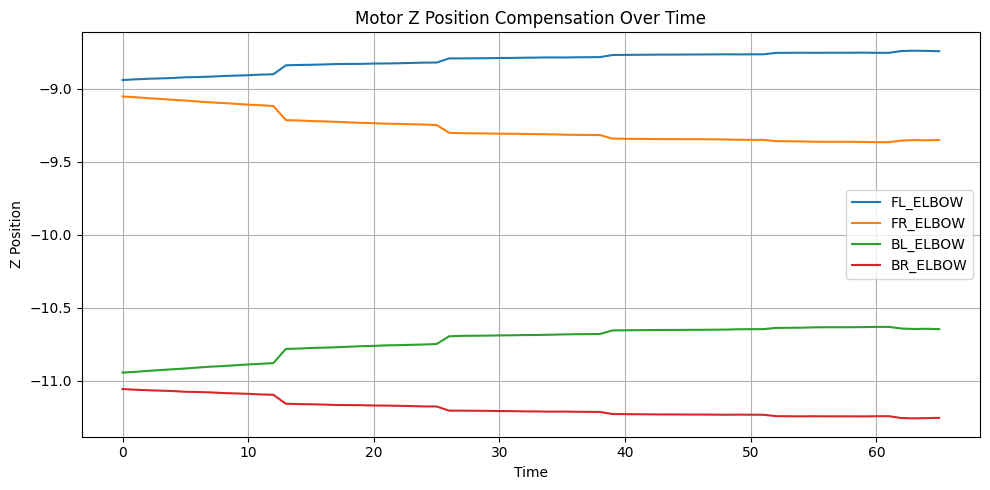

In [13]:
# --- Imports and Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# --- Data Models ---
@dataclass
class GyroData:
    roll: float  # Rotation around X (forward)
    pitch: float  # Rotation around Y (side)
    yaw: float  # Rotation around Z (vertical)

@dataclass
class MotorState:
    name: str
    z_position: float

# --- Constants ---
MOTOR_NAMES = [
    "FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"
]

# --- Coordinate Frame Agreement ---
# Assume:
#   X (roll): forward
#   Y (pitch): left
#   Z (yaw): up
# Motors control Z height
#   - Pitch forward = lower front, raise back
#   - Roll right = raise left, lower right

# --- Motor Initialization ---
def init_motor_states():
    return {name: MotorState(name, -10.0) for name in MOTOR_NAMES}

# --- Gyroscope Compensation Logic ---
def compensate_motors(gyro: GyroData, motors: dict, pitch_gain=0.2, roll_gain=0.1):
    updated = {}
    for name, state in motors.items():
        z = state.z_position
        
        if name.startswith("FL") or name.startswith("FR"):
            z -= pitch_gain * gyro.pitch  # lower front for forward pitch
        if name.startswith("BL") or name.startswith("BR"):
            z += pitch_gain * gyro.pitch  # raise back for forward pitch

        if name.startswith("FL") or name.startswith("BL"):
            z -= roll_gain * gyro.roll   # lower left for right roll
        if name.startswith("FR") or name.startswith("BR"):
            z += roll_gain * gyro.roll   # raise right for right roll

        updated[name] = MotorState(name, z)
    return updated

# --- Simulate Gyro Inputs ---
gyro_data_samples = [
    GyroData(-0.5629, -5.0092, 0.0666), GyroData(-0.6124, -5.0091, 0.0758), GyroData(-0.6621, -5.0020, 0.0919),
    GyroData(-0.7045, -4.9949, 0.1007), GyroData(-0.7469, -4.9878, 0.1095), GyroData(-0.7963, -4.9877, 0.1187),
    GyroData(-0.8386, -4.9736, 0.1274), GyroData(-0.8810, -4.9665, 0.1362), GyroData(-0.9234, -4.9664, 0.1451),
    GyroData(-0.9658, -4.9593, 0.1538), GyroData(-1.0081, -4.9522, 0.1626), GyroData(-1.0505, -4.9520, 0.1714),
    GyroData(-1.0859, -4.9449, 0.1799), GyroData(-1.8789, -4.8566, 0.3947), GyroData(-1.9003, -4.8564, 0.4027),
    GyroData(-1.9287, -4.8495, 0.4108), GyroData(-1.9500, -4.8492, 0.4187), GyroData(-1.9784, -4.8490, 0.4269),
    GyroData(-1.9997, -4.8418, 0.4346), GyroData(-2.0210, -4.8346, 0.4424), GyroData(-2.0423, -4.8344, 0.4503),
    GyroData(-2.0636, -4.8272, 0.4581), GyroData(-2.0779, -4.8270, 0.4657), GyroData(-2.0993, -4.8267, 0.4736),
    GyroData(-2.1206, -4.8265, 0.4815), GyroData(-2.1419, -4.8193, 0.4892), GyroData(-2.5481, -4.7580, 0.6661),
    GyroData(-2.5623, -4.7508, 0.6735), GyroData(-2.5696, -4.7506, 0.6808), GyroData(-2.5769, -4.7503, 0.6881),
    GyroData(-2.5912, -4.7501, 0.6957), GyroData(-2.5985, -4.7499, 0.7030), GyroData(-2.6126, -4.7498, 0.7036),
    GyroData(-2.6199, -4.7496, 0.7109), GyroData(-2.6342, -4.7493, 0.7184), GyroData(-2.6414, -4.7421, 0.7256),
    GyroData(-2.6557, -4.7418, 0.7332), GyroData(-2.6630, -4.7416, 0.7405), GyroData(-2.6700, -4.7416, 0.7408),
    GyroData(-2.8651, -4.7160, 0.8883), GyroData(-2.8724, -4.7157, 0.8956), GyroData(-2.8797, -4.7155, 0.9029),
    GyroData(-2.8870, -4.7152, 0.9102), GyroData(-2.8943, -4.7150, 0.9175), GyroData(-2.8946, -4.7148, 0.9245),
    GyroData(-2.9016, -4.7148, 0.9248), GyroData(-2.9019, -4.7146, 0.9318), GyroData(-2.9091, -4.7143, 0.9391),
    GyroData(-2.9164, -4.7141, 0.9464), GyroData(-2.9237, -4.7069, 0.9535), GyroData(-2.9310, -4.7066, 0.9608),
    GyroData(-2.9313, -4.7064, 0.9678), GyroData(-3.0216, -4.7090, 1.1187), GyroData(-3.0289, -4.7087, 1.1260),
    GyroData(-3.0362, -4.7085, 1.1333), GyroData(-3.0437, -4.7010, 1.1474), GyroData(-3.0510, -4.7008, 1.1547),
    GyroData(-3.0513, -4.7006, 1.1617), GyroData(-3.0516, -4.7004, 1.1687), GyroData(-3.0589, -4.7001, 1.1760),
    GyroData(-3.0591, -4.6929, 1.1828), GyroData(-3.0594, -4.6927, 1.1898), GyroData(-3.0668, -4.7512, 1.3528),
    GyroData(-3.0599, -4.7653, 1.3528), GyroData(-3.0604, -4.7579, 1.3667), GyroData(-3.0382, -4.7590, 1.3378)
    
]

# --- Simulation Loop ---
records = []
for t, gyro in enumerate(gyro_data_samples):
    motors = init_motor_states()
    compensated = compensate_motors(gyro, motors)
    row = {"time": t, "roll": gyro.roll, "pitch": gyro.pitch, "yaw": gyro.yaw}
    row.update({name: state.z_position for name, state in compensated.items()})
    records.append(row)

# --- Create DataFrame ---
df = pd.DataFrame(records)
display(df)

# --- Plot Result ---
plt.figure(figsize=(10, 5))
for motor in MOTOR_NAMES:
    plt.plot(df['time'], df[motor], label=motor)

plt.title("Motor Z Position Compensation Over Time")
plt.xlabel("Time")
plt.ylabel("Z Position")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


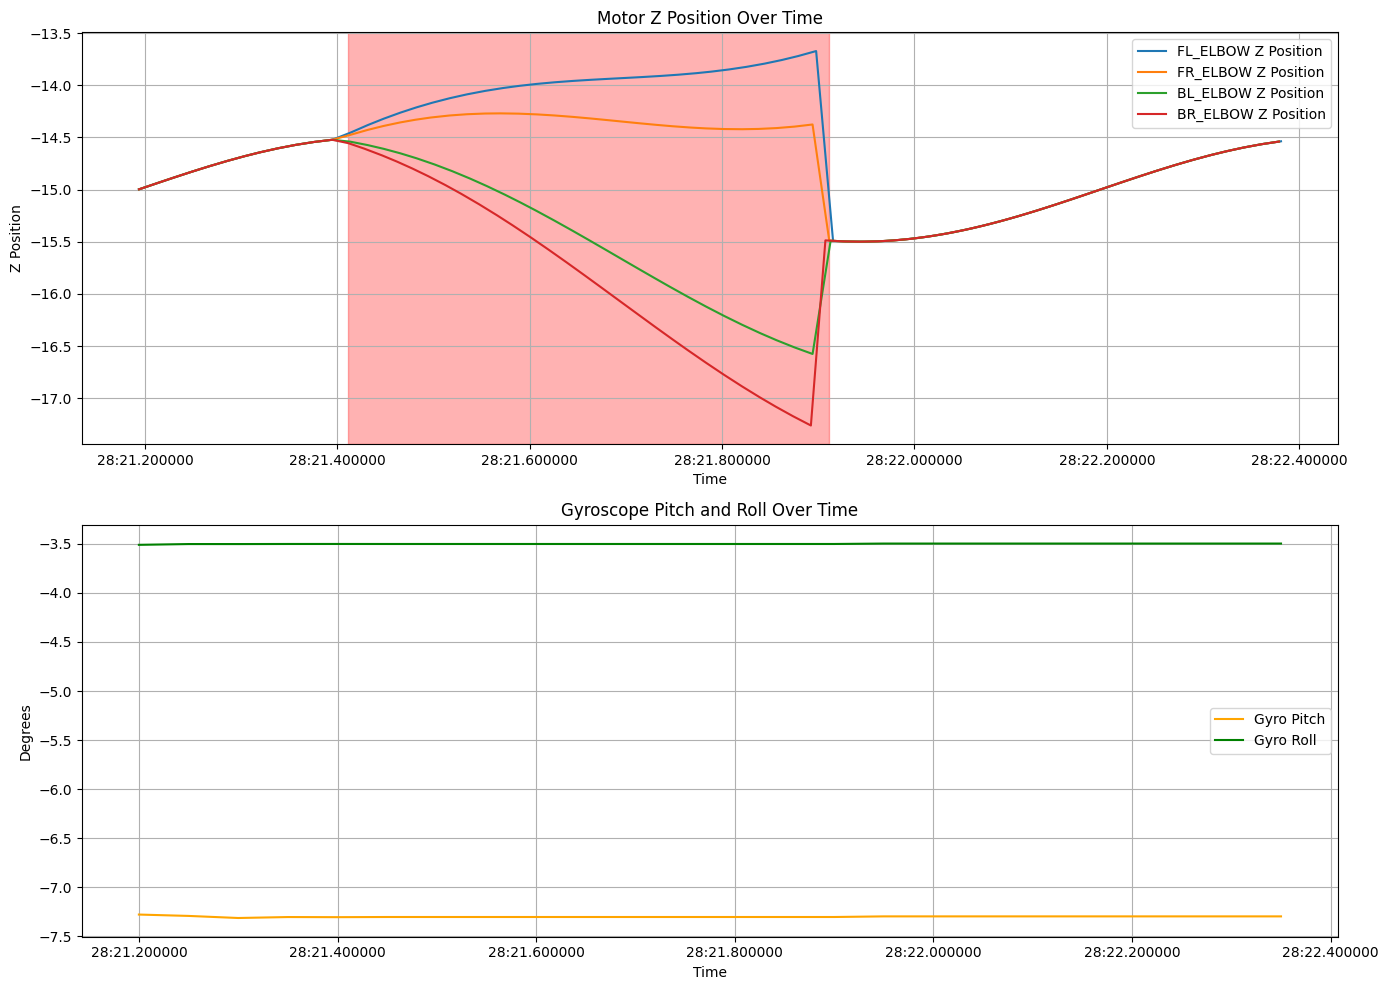

In [26]:
# --- Imports ---
import time
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import deque

# --- Settings ---
MOTOR_UPDATE_INTERVAL = 0.015
GYRO_UPDATE_INTERVAL = 0.01
SIMULATION_DURATION = 1.2
COMPENSATION_DURATION = 0.5  # Full compensation cycle

# --- Helper Classes ---
@dataclass
class GyroData:
    roll: float
    pitch: float
    yaw: float

@dataclass
class MotorState:
    name: str
    z_position: float

# --- Globals ---
latest_gyro = None
gyro_staging_buffer = deque(maxlen=10)
motor_names = ["FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"]
log_data = []
start_time = None
fsm_state = "FLAT_IDLE"
compensation_start_time = None
ramp_detected_time = None
ready_to_compensate = False
saved_gyro = None

# --- FSM Logic ---
def is_on_ramp(gyro: GyroData, pitch_thresh=2.0, roll_thresh=2.0):
    return abs(gyro.pitch) > pitch_thresh or abs(gyro.roll) > roll_thresh

def update_fsm_state(gyro):
    global fsm_state, compensation_start_time, ramp_detected_time, ready_to_compensate, saved_gyro
    now = time.time()
    if fsm_state == "ON_RAMP_COMPENSATING":
        if now - compensation_start_time > COMPENSATION_DURATION:
            fsm_state = "RECOVERY"
            ramp_detected_time = None
            ready_to_compensate = False
    elif fsm_state == "RECOVERY":
        if now - compensation_start_time > COMPENSATION_DURATION + 0.2:
            fsm_state = "FLAT_IDLE"
    elif is_on_ramp(gyro):
        if ramp_detected_time is None:
            ramp_detected_time = now
        elif now - ramp_detected_time >= 0.2 and not ready_to_compensate:
            fsm_state = "ON_RAMP_COMPENSATING"
            compensation_start_time = now
            saved_gyro = gyro
            ready_to_compensate = True
    else:
        fsm_state = "FLAT_IDLE"
        ramp_detected_time = None
        ready_to_compensate = False

# --- Core Functions ---
def generate_realistic_motor_data(name, t):
    base = -15
    z_position = base + 0.5 * np.sin(2 * np.pi * t)
    return MotorState(name=name, z_position=z_position)

def compute_compensation(motor: MotorState, gyro: GyroData, progress: float = 1.0, pitch_gain=0.2, roll_gain=0.1):
    z = motor.z_position
    pitch_adjust = pitch_gain * gyro.pitch * progress
    roll_adjust = roll_gain * gyro.roll * progress

    if motor.name.startswith("FL") or motor.name.startswith("FR"):
        z -= pitch_adjust
    if motor.name.startswith("BL") or motor.name.startswith("BR"):
        z += pitch_adjust
    if motor.name.startswith("FL") or motor.name.startswith("BL"):
        z -= roll_adjust
    if motor.name.startswith("FR") or motor.name.startswith("BR"):
        z += roll_adjust
    return MotorState(name=motor.name, z_position=z)

def send_to_motor(motor: MotorState, timestamp, gyro: GyroData):
    log_data.append({
        "timestamp": timestamp,
        "motor_name": motor.name,
        "z_position": motor.z_position,
        "gyro_roll": gyro.roll,
        "gyro_pitch": gyro.pitch,
        "gyro_yaw": gyro.yaw,
        "fsm_state": fsm_state
    })

# --- Threads ---
def gyro_data_thread():
    global latest_gyro
    index = 0
    while time.time() - start_time < SIMULATION_DURATION and index < len(gyro_data_samples):
        gyro = gyro_data_samples[index]
        gyro_staging_buffer.append(gyro)
        # 
        # if len(gyro_staging_buffer) == gyro_staging_buffer.maxlen:
        #     avg_pitch = sum(g.pitch for g in gyro_staging_buffer) / len(gyro_staging_buffer)
        #     avg_roll = sum(g.roll for g in gyro_staging_buffer) / len(gyro_staging_buffer)
        #     smoothed_gyro = GyroData(roll=avg_roll, pitch=avg_pitch, yaw=gyro.yaw)
        #     update_fsm_state(smoothed_gyro)
        #     latest_gyro = smoothed_gyro
        # else:
        #     update_fsm_state(gyro)
        latest_gyro = gyro
        index += 1
        time.sleep(GYRO_UPDATE_INTERVAL)

def motor_data_thread(name):
    while time.time() - start_time < SIMULATION_DURATION:
        elapsed_time = time.time() - start_time
        motor_position = generate_realistic_motor_data(name, elapsed_time)

        gyro = saved_gyro if fsm_state == "ON_RAMP_COMPENSATING" else latest_gyro
        if gyro:
            if fsm_state == "ON_RAMP_COMPENSATING":
                progress = min((time.time() - compensation_start_time) / COMPENSATION_DURATION, 1.0)
                compensated_motor = compute_compensation(motor_position, gyro, progress)
                send_to_motor(compensated_motor, time.time(), gyro)
            else:
                send_to_motor(motor_position, time.time(), gyro)

        time.sleep(MOTOR_UPDATE_INTERVAL)

# --- Simulation Setup ---
from numpy.random import normal
gyro_data_samples = [GyroData(roll, pitch, yaw) for roll, pitch, yaw in zip(
    normal(-3.5, 0.01, 60),
    normal(-7.3, 0.01, 60),
    normal(-4.0, 1.0, 60)
)]

# --- Run Simulation ---
start_time = time.time()
threads = [threading.Thread(target=gyro_data_thread)]
threads += [threading.Thread(target=motor_data_thread, args=(name,)) for name in motor_names]

for t in threads: t.start()
for t in threads: t.join()

# --- Display Result ---
df = pd.DataFrame(log_data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

plt.figure(figsize=(14, 10))

# Plot motor Z positions
plt.subplot(2, 1, 1)
for motor in motor_names:
    motor_df = df[df['motor_name'] == motor]
    plt.plot(motor_df['timestamp'], motor_df['z_position'], label=f"{motor} Z Position")
plt.title("Motor Z Position Over Time")
plt.xlabel("Time")
plt.ylabel("Z Position")
plt.legend()
plt.grid(True)

# Highlight all compensation periods
for _, group in df[df['fsm_state'] == 'ON_RAMP_COMPENSATING'].groupby((df['fsm_state'] != df['fsm_state'].shift()).cumsum()):
    if not group.empty:
        start = group['timestamp'].iloc[0]
        end = start + pd.Timedelta(seconds=COMPENSATION_DURATION)
        plt.axvspan(start, end, color='red', alpha=0.3)

# Plot gyro pitch and roll
plt.subplot(2, 1, 2)
gyro_df = df.drop_duplicates(subset=['timestamp'])[['timestamp', 'gyro_roll', 'gyro_pitch']]
gyro_df = gyro_df.set_index('timestamp').resample('50ms').ffill().reset_index()
plt.plot(gyro_df['timestamp'], gyro_df['gyro_pitch'], label="Gyro Pitch", color='orange')
plt.plot(gyro_df['timestamp'], gyro_df['gyro_roll'], label="Gyro Roll", color='green')
plt.title("Gyroscope Pitch and Roll Over Time")
plt.xlabel("Time")
plt.ylabel("Degrees")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

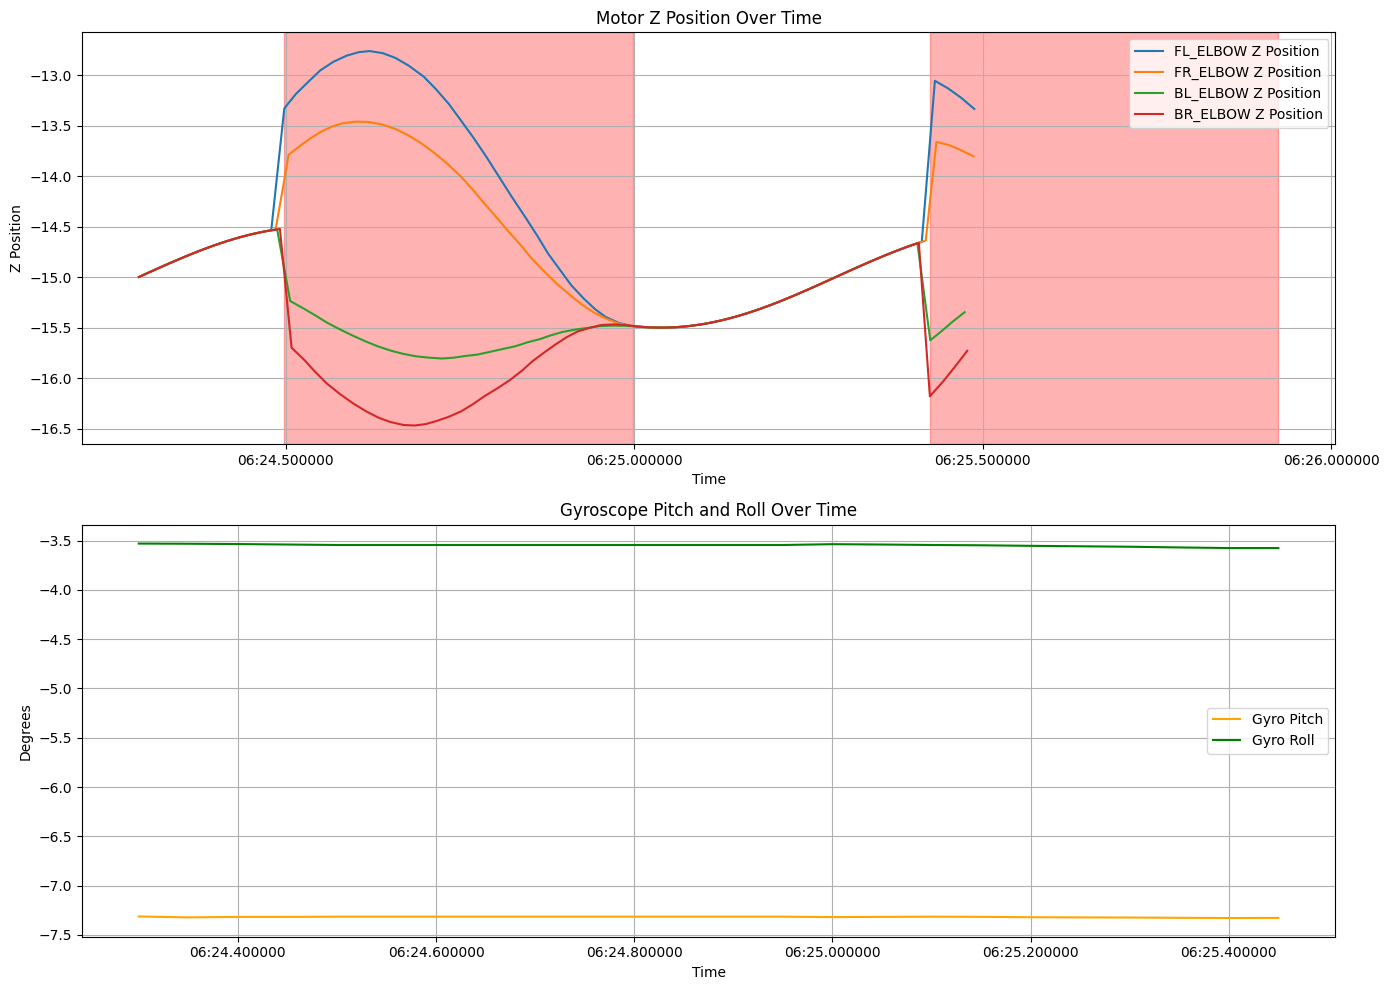

In [30]:
# --- Imports ---
import time
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import deque

# --- Settings ---
MOTOR_UPDATE_INTERVAL = 0.015
GYRO_UPDATE_INTERVAL = 0.01
SIMULATION_DURATION = 1.2
COMPENSATION_DURATION = 0.5  # Full compensation cycle

# --- Helper Classes ---
@dataclass
class GyroData:
    roll: float
    pitch: float
    yaw: float

@dataclass
class MotorState:
    name: str
    z_position: float

# --- Globals ---
latest_gyro = None
gyro_staging_buffer = deque(maxlen=10)
motor_names = ["FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"]
log_data = []
start_time = None
fsm_state = "FLAT_IDLE"
compensation_start_time = None
ramp_detected_time = None
ready_to_compensate = False
saved_gyro = None

# --- FSM Logic ---
def is_on_ramp(gyro: GyroData, pitch_thresh=2.0, roll_thresh=2.0):
    return abs(gyro.pitch) > pitch_thresh or abs(gyro.roll) > roll_thresh

def update_fsm_state(gyro):
    global fsm_state, compensation_start_time, ramp_detected_time, ready_to_compensate, saved_gyro
    now = time.time()
    if fsm_state == "ON_RAMP_COMPENSATING":
        if now - compensation_start_time > COMPENSATION_DURATION:
            fsm_state = "RECOVERY"
            ramp_detected_time = None
            ready_to_compensate = False
    elif fsm_state == "RECOVERY":
        if now - compensation_start_time > COMPENSATION_DURATION + 0.2:
            fsm_state = "FLAT_IDLE"
    elif is_on_ramp(gyro):
        if ramp_detected_time is None:
            ramp_detected_time = now
        elif now - ramp_detected_time >= 0.2 and not ready_to_compensate:
            fsm_state = "ON_RAMP_COMPENSATING"
            compensation_start_time = now
            saved_gyro = gyro
            ready_to_compensate = True
    else:
        fsm_state = "FLAT_IDLE"
        ramp_detected_time = None
        ready_to_compensate = False

# --- Core Functions ---
def generate_realistic_motor_data(name, t):
    base = -15
    z_position = base + 0.5 * np.sin(2 * np.pi * t)
    return MotorState(name=name, z_position=z_position)

def compute_compensation(motor: MotorState, gyro: GyroData, tick: int, pitch_gain=0.2, roll_gain=0.1, step_period=40):
    z = motor.z_position
    phase = (tick % step_period) / step_period
    gait_scale = 0.5 * (1 - np.cos(2 * np.pi * phase))

    pitch_adjust = pitch_gain * gyro.pitch * gait_scale
    roll_adjust = roll_gain * gyro.roll * gait_scale

    if motor.name.startswith("FL") or motor.name.startswith("FR"):
        z -= pitch_adjust
    if motor.name.startswith("BL") or motor.name.startswith("BR"):
        z += pitch_adjust
    if motor.name.startswith("FL") or motor.name.startswith("BL"):
        z -= roll_adjust
    if motor.name.startswith("FR") or motor.name.startswith("BR"):
        z += roll_adjust
    return MotorState(name=motor.name, z_position=z)

def send_to_motor(motor: MotorState, timestamp, gyro: GyroData):
    log_data.append({
        "timestamp": timestamp,
        "motor_name": motor.name,
        "z_position": motor.z_position,
        "gyro_roll": gyro.roll,
        "gyro_pitch": gyro.pitch,
        "gyro_yaw": gyro.yaw,
        "fsm_state": fsm_state
    })

# --- Threads ---
def gyro_data_thread():
    global latest_gyro
    index = 0
    while time.time() - start_time < SIMULATION_DURATION and index < len(gyro_data_samples):
        gyro = gyro_data_samples[index]
        gyro_staging_buffer.append(gyro)

        if len(gyro_staging_buffer) == gyro_staging_buffer.maxlen:
            avg_pitch = sum(g.pitch for g in gyro_staging_buffer) / len(gyro_staging_buffer)
            avg_roll = sum(g.roll for g in gyro_staging_buffer) / len(gyro_staging_buffer)
            smoothed_gyro = GyroData(roll=avg_roll, pitch=avg_pitch, yaw=gyro.yaw)
            update_fsm_state(smoothed_gyro)
            latest_gyro = smoothed_gyro
        else:
            update_fsm_state(gyro)
            latest_gyro = gyro
        index += 1
        time.sleep(GYRO_UPDATE_INTERVAL)

def motor_data_thread(name):
    tick = 0
    while time.time() - start_time < SIMULATION_DURATION:
        elapsed_time = time.time() - start_time
        motor_position = generate_realistic_motor_data(name, elapsed_time)

        gyro = saved_gyro if fsm_state == "ON_RAMP_COMPENSATING" else latest_gyro
        if gyro:
            if fsm_state == "ON_RAMP_COMPENSATING":
                compensated_motor = compute_compensation(motor_position, gyro, tick)
                send_to_motor(compensated_motor, time.time(), gyro)
            else:
                send_to_motor(motor_position, time.time(), gyro)

        tick += 1
        time.sleep(MOTOR_UPDATE_INTERVAL)

# --- Sample Data ---
gyro_data_samples = [
    GyroData(-3.5295, -7.3133, -4.0386), GyroData(-3.5286, -7.3137, -4.0527),
    GyroData(-3.5270, -7.3213, -4.0736), GyroData(-3.5326, -7.3221, -4.0942),
    GyroData(-3.5313, -7.3227, -4.1153), GyroData(-3.5236, -7.3159, -4.1300),
    GyroData(-3.5427, -7.3185, -4.6060), GyroData(-3.5418, -7.3189, -4.6200),
    GyroData(-3.5405, -7.3195, -4.6411), GyroData(-3.5468, -7.3132, -4.6549),
    GyroData(-3.5457, -7.3142, -4.6763), GyroData(-3.5447, -7.3146, -4.6903),
    GyroData(-3.5434, -7.3152, -4.7114), GyroData(-3.5420, -7.3158, -4.7325),
    GyroData(-3.5411, -7.3162, -4.7466), GyroData(-3.5470, -7.3101, -4.7674),
    GyroData(-3.5458, -7.3175, -4.7812), GyroData(-3.5444, -7.3181, -4.8023),
    GyroData(-3.5433, -7.3117, -4.8236), GyroData(-3.5559, -7.3215, -5.2931),
    GyroData(-3.5545, -7.3220, -5.3142), GyroData(-3.5531, -7.3226, -5.3353),
    GyroData(-3.5592, -7.3233, -5.3488), GyroData(-3.5578, -7.3240, -5.3699),
    GyroData(-3.5569, -7.3243, -5.3840), GyroData(-3.5555, -7.3249, -5.4051),
    GyroData(-3.5548, -7.3257, -5.4194), GyroData(-3.5608, -7.3197, -5.4403),
    GyroData(-3.5598, -7.3201, -5.4543), GyroData(-3.5585, -7.3207, -5.4760),
    GyroData(-3.5641, -7.3216, -5.4960), GyroData(-3.5632, -7.3220, -5.5101),
    GyroData(-3.5686, -7.3315, -5.9800), GyroData(-3.5747, -7.3323, -5.9936),
    GyroData(-3.5733, -7.3328, -6.0147), GyroData(-3.5719, -7.3334, -6.0358),
    GyroData(-3.5784, -7.3272, -6.0496), GyroData(-3.5772, -7.3282, -6.0710),
    GyroData(-3.5758, -7.3288, -6.0921), GyroData(-3.5752, -7.3222, -6.1063),
    GyroData(-3.5735, -7.3298, -6.1272), GyroData(-3.5726, -7.3302, -6.1412),
    GyroData(-3.5786, -7.3241, -6.1621), GyroData(-3.5773, -7.3315, -6.1759),
    GyroData(-3.5694, -7.3252, -6.1980), GyroData(-3.5671, -7.3342, -6.6751),
    GyroData(-3.5659, -7.3352, -6.6966), GyroData(-3.5649, -7.3356, -6.7106),
    GyroData(-3.5639, -7.3292, -6.7319), GyroData(-3.5630, -7.3296, -6.7459),
    GyroData(-3.5616, -7.3301, -6.7670), GyroData(-3.5602, -7.3307, -6.7881),
] * 10

# --- Run Simulation ---
start_time = time.time()
threads = [threading.Thread(target=gyro_data_thread)]
threads += [threading.Thread(target=motor_data_thread, args=(name,)) for name in motor_names]

for t in threads: t.start()
for t in threads: t.join()

# --- Display Result ---
df = pd.DataFrame(log_data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

plt.figure(figsize=(14, 10))

# Plot motor Z positions
plt.subplot(2, 1, 1)
for motor in motor_names:
    motor_df = df[df['motor_name'] == motor]
    plt.plot(motor_df['timestamp'], motor_df['z_position'], label=f"{motor} Z Position")
plt.title("Motor Z Position Over Time")
plt.xlabel("Time")
plt.ylabel("Z Position")
plt.legend()
plt.grid(True)

# Highlight compensation periods
for _, group in df[df['fsm_state'] == 'ON_RAMP_COMPENSATING'].groupby((df['fsm_state'] != df['fsm_state'].shift()).cumsum()):
    if not group.empty:
        start = group['timestamp'].iloc[0]
        end = start + pd.Timedelta(seconds=COMPENSATION_DURATION)
        plt.axvspan(start, end, color='red', alpha=0.3)

# Plot gyro pitch and roll
plt.subplot(2, 1, 2)
gyro_df = df.drop_duplicates(subset=['timestamp'])[['timestamp', 'gyro_roll', 'gyro_pitch']]
gyro_df = gyro_df.set_index('timestamp').resample('50ms').ffill().reset_index()
plt.plot(gyro_df['timestamp'], gyro_df['gyro_pitch'], label="Gyro Pitch", color='orange')
plt.plot(gyro_df['timestamp'], gyro_df['gyro_roll'], label="Gyro Roll", color='green')
plt.title("Gyroscope Pitch and Roll Over Time")
plt.xlabel("Time")
plt.ylabel("Degrees")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

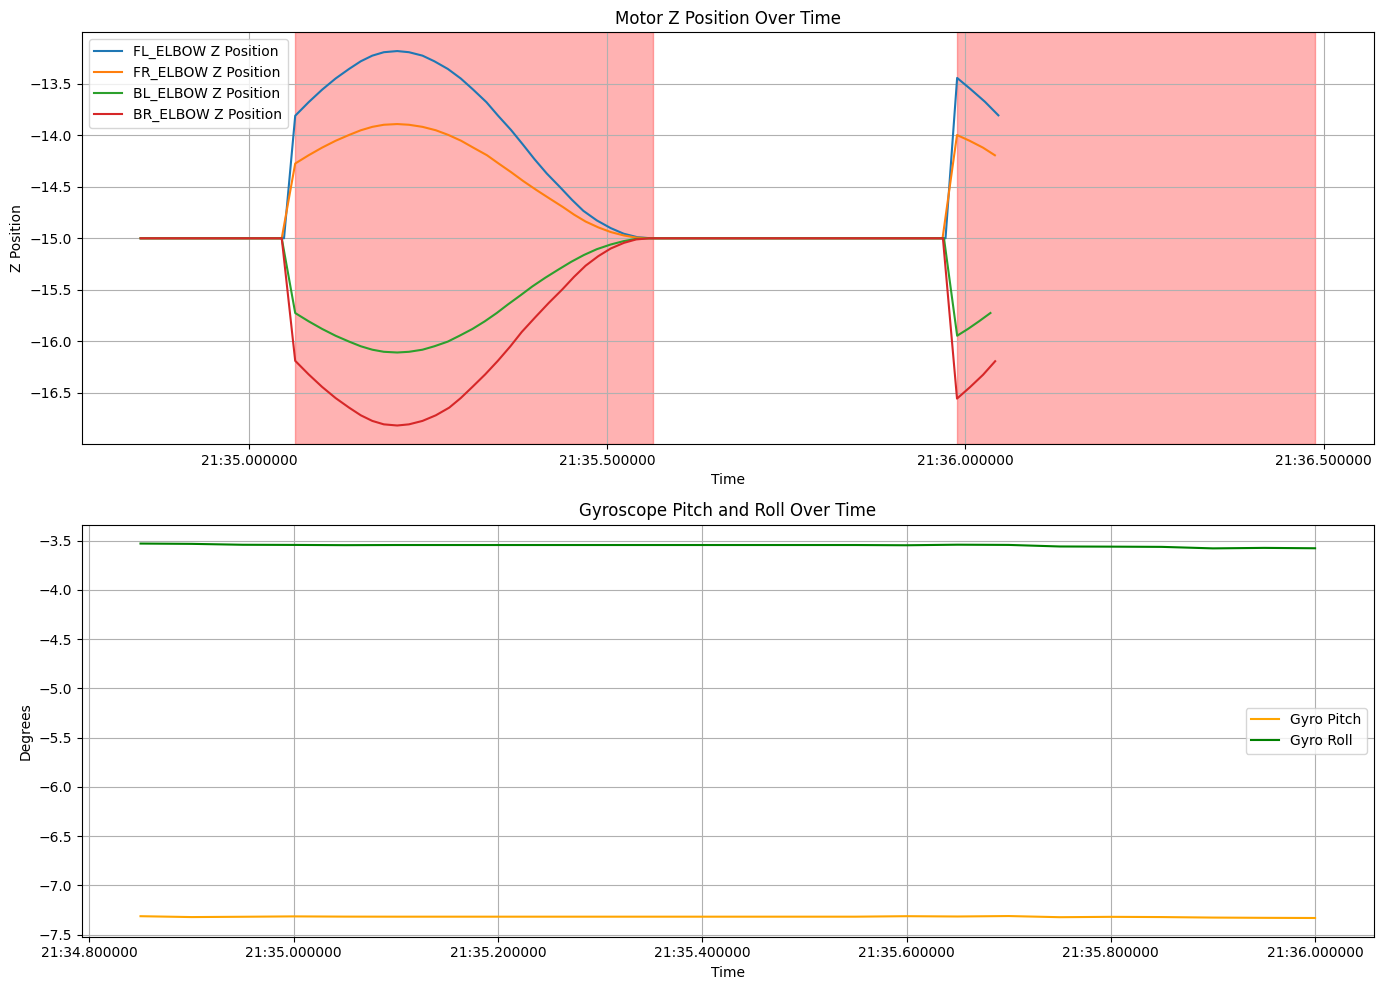

In [31]:
# --- Imports ---
import time
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import deque

# --- Settings ---
MOTOR_UPDATE_INTERVAL = 0.015
GYRO_UPDATE_INTERVAL = 0.01
SIMULATION_DURATION = 1.2
COMPENSATION_DURATION = 0.5

# --- Helper Classes ---
@dataclass
class GyroData:
    roll: float
    pitch: float
    yaw: float

@dataclass
class MotorState:
    name: str
    z_position: float

# --- Globals ---
latest_gyro = None
motor_names = ["FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"]
log_data = []
start_time = None
fsm_state = "FLAT_IDLE"
compensation_start_time = None
ramp_detected_time = None
ready_to_compensate = False
saved_gyro = None

# --- FSM Logic ---
def is_on_ramp(gyro: GyroData, pitch_thresh=2.0, roll_thresh=2.0):
    return abs(gyro.pitch) > pitch_thresh or abs(gyro.roll) > roll_thresh

def update_fsm_state(gyro):
    global fsm_state, compensation_start_time, ramp_detected_time, ready_to_compensate, saved_gyro
    now = time.time()
    if fsm_state == "ON_RAMP_COMPENSATING":
        if now - compensation_start_time > COMPENSATION_DURATION:
            fsm_state = "RECOVERY"
            ramp_detected_time = None
            ready_to_compensate = False
    elif fsm_state == "RECOVERY":
        if now - compensation_start_time > COMPENSATION_DURATION + 0.2:
            fsm_state = "FLAT_IDLE"
    elif is_on_ramp(gyro):
        if ramp_detected_time is None:
            ramp_detected_time = now
        elif now - ramp_detected_time >= 0.2 and not ready_to_compensate:
            fsm_state = "ON_RAMP_COMPENSATING"
            compensation_start_time = now
            saved_gyro = gyro
            ready_to_compensate = True
    else:
        fsm_state = "FLAT_IDLE"
        ramp_detected_time = None
        ready_to_compensate = False

# --- Core Functions ---
def compute_compensation(motor: MotorState, gyro: GyroData, tick: int, pitch_gain=0.2, roll_gain=0.1, step_period=40):
    z = motor.z_position
    phase = (tick % step_period) / step_period
    gait_scale = 0.5 * (1 - np.cos(2 * np.pi * phase))

    pitch_adjust = pitch_gain * gyro.pitch * gait_scale
    roll_adjust = roll_gain * gyro.roll * gait_scale

    if motor.name.startswith("FL") or motor.name.startswith("FR"):
        z -= pitch_adjust
    if motor.name.startswith("BL") or motor.name.startswith("BR"):
        z += pitch_adjust
    if motor.name.startswith("FL") or motor.name.startswith("BL"):
        z -= roll_adjust
    if motor.name.startswith("FR") or motor.name.startswith("BR"):
        z += roll_adjust
    return MotorState(name=motor.name, z_position=z)

def send_to_motor(motor: MotorState, timestamp, gyro: GyroData):
    log_data.append({
        "timestamp": timestamp,
        "motor_name": motor.name,
        "z_position": motor.z_position,
        "gyro_roll": gyro.roll,
        "gyro_pitch": gyro.pitch,
        "gyro_yaw": gyro.yaw,
        "fsm_state": fsm_state
    })

# --- Threads ---
def gyro_data_thread():
    global latest_gyro
    index = 0
    while time.time() - start_time < SIMULATION_DURATION and index < len(gyro_data_samples):
        gyro = gyro_data_samples[index]
        update_fsm_state(gyro)
        latest_gyro = gyro
        index += 1
        time.sleep(GYRO_UPDATE_INTERVAL)

def motor_data_thread(name):
    tick = 0
    while time.time() - start_time < SIMULATION_DURATION:
        motor_position = MotorState(name=name, z_position=-15.0)
        gyro = saved_gyro if fsm_state == "ON_RAMP_COMPENSATING" else latest_gyro
        if gyro:
            if fsm_state == "ON_RAMP_COMPENSATING":
                compensated_motor = compute_compensation(motor_position, gyro, tick)
                send_to_motor(compensated_motor, time.time(), gyro)
            else:
                send_to_motor(motor_position, time.time(), gyro)
        tick += 1
        time.sleep(MOTOR_UPDATE_INTERVAL)

# --- Sample Data ---
gyro_data_samples = [
    GyroData(-3.5295, -7.3133, -4.0386), GyroData(-3.5286, -7.3137, -4.0527),
    GyroData(-3.5270, -7.3213, -4.0736), GyroData(-3.5326, -7.3221, -4.0942),
    GyroData(-3.5313, -7.3227, -4.1153), GyroData(-3.5236, -7.3159, -4.1300),
    GyroData(-3.5427, -7.3185, -4.6060), GyroData(-3.5418, -7.3189, -4.6200),
    GyroData(-3.5405, -7.3195, -4.6411), GyroData(-3.5468, -7.3132, -4.6549),
    GyroData(-3.5457, -7.3142, -4.6763), GyroData(-3.5447, -7.3146, -4.6903),
    GyroData(-3.5434, -7.3152, -4.7114), GyroData(-3.5420, -7.3158, -4.7325),
    GyroData(-3.5411, -7.3162, -4.7466), GyroData(-3.5470, -7.3101, -4.7674),
    GyroData(-3.5458, -7.3175, -4.7812), GyroData(-3.5444, -7.3181, -4.8023),
    GyroData(-3.5433, -7.3117, -4.8236), GyroData(-3.5559, -7.3215, -5.2931),
    GyroData(-3.5545, -7.3220, -5.3142), GyroData(-3.5531, -7.3226, -5.3353),
    GyroData(-3.5592, -7.3233, -5.3488), GyroData(-3.5578, -7.3240, -5.3699),
    GyroData(-3.5569, -7.3243, -5.3840), GyroData(-3.5555, -7.3249, -5.4051),
    GyroData(-3.5548, -7.3257, -5.4194), GyroData(-3.5608, -7.3197, -5.4403),
    GyroData(-3.5598, -7.3201, -5.4543), GyroData(-3.5585, -7.3207, -5.4760),
    GyroData(-3.5641, -7.3216, -5.4960), GyroData(-3.5632, -7.3220, -5.5101),
    GyroData(-3.5686, -7.3315, -5.9800), GyroData(-3.5747, -7.3323, -5.9936),
    GyroData(-3.5733, -7.3328, -6.0147), GyroData(-3.5719, -7.3334, -6.0358),
    GyroData(-3.5784, -7.3272, -6.0496), GyroData(-3.5772, -7.3282, -6.0710),
    GyroData(-3.5758, -7.3288, -6.0921), GyroData(-3.5752, -7.3222, -6.1063),
    GyroData(-3.5735, -7.3298, -6.1272), GyroData(-3.5726, -7.3302, -6.1412),
    GyroData(-3.5786, -7.3241, -6.1621), GyroData(-3.5773, -7.3315, -6.1759),
    GyroData(-3.5694, -7.3252, -6.1980), GyroData(-3.5671, -7.3342, -6.6751),
    GyroData(-3.5659, -7.3352, -6.6966), GyroData(-3.5649, -7.3356, -6.7106),
    GyroData(-3.5639, -7.3292, -6.7319), GyroData(-3.5630, -7.3296, -6.7459),
    GyroData(-3.5616, -7.3301, -6.7670), GyroData(-3.5602, -7.3307, -6.7881),
] * 10

# --- Run Simulation ---
start_time = time.time()
threads = [threading.Thread(target=gyro_data_thread)]
threads += [threading.Thread(target=motor_data_thread, args=(name,)) for name in motor_names]
for t in threads: t.start()
for t in threads: t.join()

# --- Display Result ---
df = pd.DataFrame(log_data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
for motor in motor_names:
    motor_df = df[df['motor_name'] == motor]
    plt.plot(motor_df['timestamp'], motor_df['z_position'], label=f"{motor} Z Position")
plt.title("Motor Z Position Over Time")
plt.xlabel("Time")
plt.ylabel("Z Position")
plt.legend()
plt.grid(True)

for _, group in df[df['fsm_state'] == 'ON_RAMP_COMPENSATING'].groupby((df['fsm_state'] != df['fsm_state'].shift()).cumsum()):
    if not group.empty:
        start = group['timestamp'].iloc[0]
        end = start + pd.Timedelta(seconds=COMPENSATION_DURATION)
        plt.axvspan(start, end, color='red', alpha=0.3)

plt.subplot(2, 1, 2)
gyro_df = df.drop_duplicates(subset=['timestamp'])[['timestamp', 'gyro_roll', 'gyro_pitch']]
gyro_df = gyro_df.set_index('timestamp').resample('50ms').ffill().reset_index()
plt.plot(gyro_df['timestamp'], gyro_df['gyro_pitch'], label="Gyro Pitch", color='orange')
plt.plot(gyro_df['timestamp'], gyro_df['gyro_roll'], label="Gyro Roll", color='green')
plt.title("Gyroscope Pitch and Roll Over Time")
plt.xlabel("Time")
plt.ylabel("Degrees")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

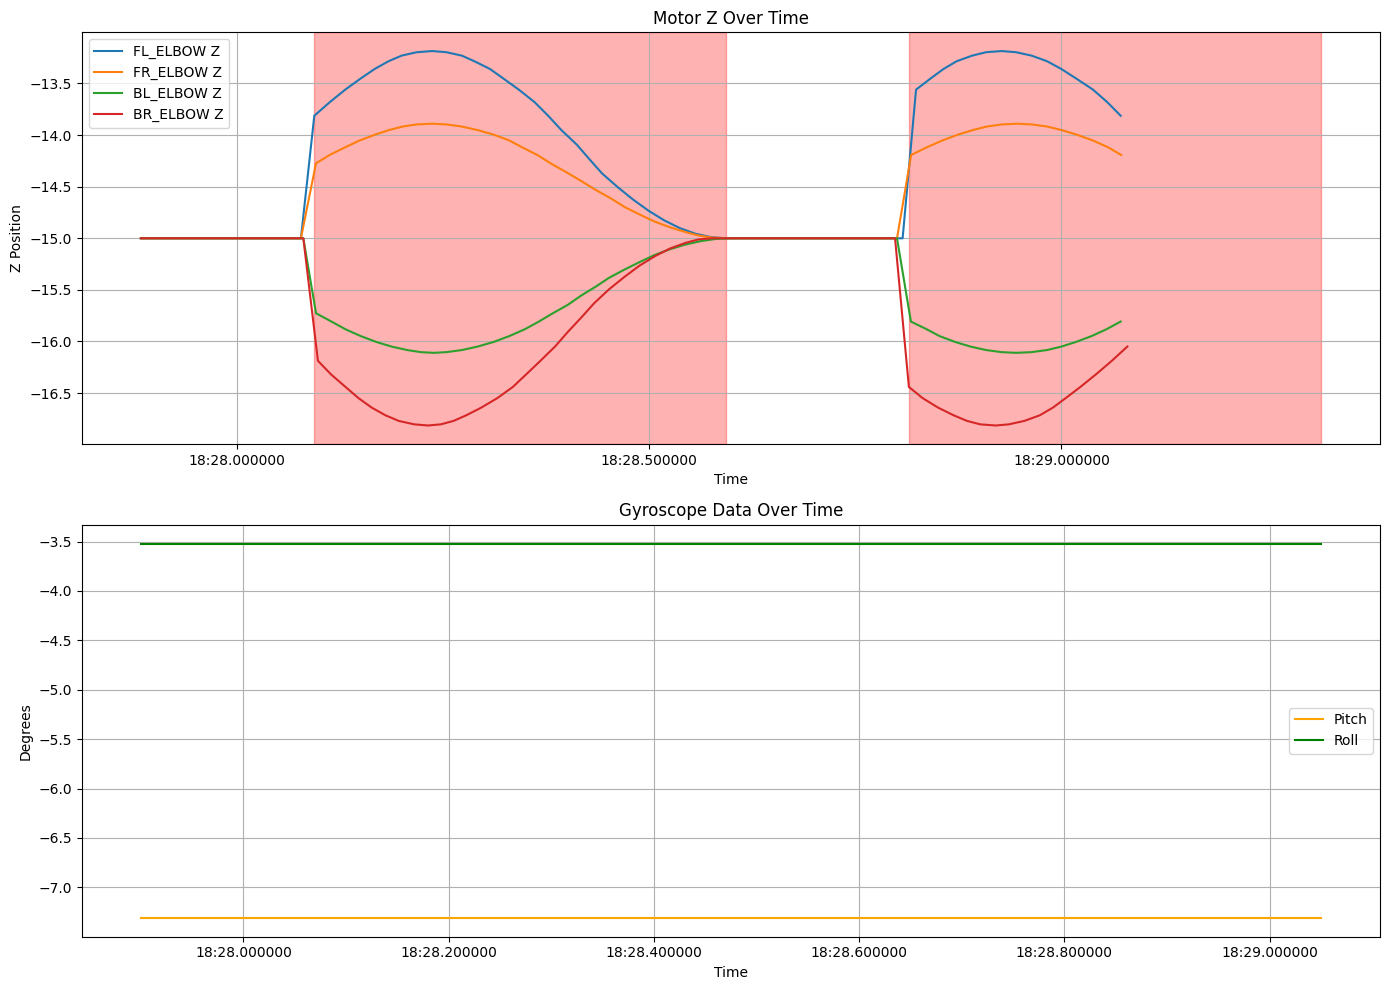

In [32]:
import time, threading, numpy as np, pandas as pd, matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import deque

# --- Constants ---
MOTOR_INTERVAL, GYRO_INTERVAL, SIM_DURATION, COMP_DURATION = 0.015, 0.01, 1.2, 0.5

@dataclass
class GyroData: roll: float; pitch: float; yaw: float
@dataclass
class MotorState: name: str; z_position: float

# --- Globals ---
motor_names = ["FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"]
log_data, latest_gyro = [], None
fsm_state, compensation_start_time, ramp_detected_time = "FLAT_IDLE", None, None
ready_to_compensate, saved_gyro = False, None

# --- FSM ---
def is_on_ramp(g: GyroData, p=2.0, r=2.0): return abs(g.pitch) > p or abs(g.roll) > r

def update_fsm_state(g):
    global fsm_state, compensation_start_time, ramp_detected_time, ready_to_compensate, saved_gyro
    now = time.time()
    if fsm_state == "ON_RAMP_COMPENSATING" and now - compensation_start_time > COMP_DURATION:
        fsm_state, ramp_detected_time, ready_to_compensate = "RECOVERY", None, False
    elif fsm_state == "RECOVERY" and now - compensation_start_time > COMP_DURATION + 0.2:
        fsm_state = "FLAT_IDLE"
    elif is_on_ramp(g):
        if not ramp_detected_time: ramp_detected_time = now
        elif now - ramp_detected_time >= 0.2 and not ready_to_compensate:
            fsm_state, compensation_start_time, saved_gyro, ready_to_compensate = "ON_RAMP_COMPENSATING", now, g, True
    else:
        fsm_state, ramp_detected_time, ready_to_compensate = "FLAT_IDLE", None, False

# --- Core Logic ---
def compute_compensation(m: MotorState, g: GyroData, t, pg=0.2, rg=0.1, sp=40):
    p = (t % sp) / sp
    gs = 0.5 * (1 - np.cos(2 * np.pi * p))
    pitch_adj, roll_adj = pg * g.pitch * gs, rg * g.roll * gs
    z = m.z_position
    if m.name.startswith("FL") or m.name.startswith("FR"): z -= pitch_adj
    if m.name.startswith("BL") or m.name.startswith("BR"): z += pitch_adj
    if m.name.startswith("FL") or m.name.startswith("BL"): z -= roll_adj
    if m.name.startswith("FR") or m.name.startswith("BR"): z += roll_adj
    return MotorState(m.name, z)

def send_to_motor(m: MotorState, ts, g: GyroData):
    log_data.append({"timestamp": ts, "motor_name": m.name, "z_position": m.z_position, "gyro_roll": g.roll, "gyro_pitch": g.pitch, "gyro_yaw": g.yaw, "fsm_state": fsm_state})

# --- Threads ---
def gyro_data_thread():
    global latest_gyro
    idx = 0
    while time.time() - start_time < SIM_DURATION and idx < len(gyro_data_samples):
        g = gyro_data_samples[idx]
        update_fsm_state(g)
        latest_gyro, idx = g, idx + 1
        time.sleep(GYRO_INTERVAL)

def motor_data_thread(name):
    t = 0
    while time.time() - start_time < SIM_DURATION:
        pos = MotorState(name, -15.0)
        g = saved_gyro if fsm_state == "ON_RAMP_COMPENSATING" else latest_gyro
        if g:
            send_to_motor(compute_compensation(pos, g, t) if fsm_state == "ON_RAMP_COMPENSATING" else pos, time.time(), g)
        t += 1
        time.sleep(MOTOR_INTERVAL)

# --- Gyro Samples ---
gyro_data_samples = [GyroData(-3.52, -7.31, -4.03 + i * 0.02) for i in range(60)] * 10

# --- Run ---
start_time = time.time()
threads = [threading.Thread(target=gyro_data_thread)] + [threading.Thread(target=motor_data_thread, args=(n,)) for n in motor_names]
for t in threads: t.start()
for t in threads: t.join()

# --- Plot ---
df = pd.DataFrame(log_data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
for n in motor_names:
    md = df[df['motor_name'] == n]
    plt.plot(md['timestamp'], md['z_position'], label=f"{n} Z")
plt.title("Motor Z Over Time"); plt.xlabel("Time"); plt.ylabel("Z Position")
plt.legend(); plt.grid(True)
for _, g in df[df['fsm_state'] == 'ON_RAMP_COMPENSATING'].groupby((df['fsm_state'] != df['fsm_state'].shift()).cumsum()):
    if not g.empty:
        s, e = g['timestamp'].iloc[0], g['timestamp'].iloc[0] + pd.Timedelta(seconds=COMP_DURATION)
        plt.axvspan(s, e, color='red', alpha=0.3)
plt.subplot(2, 1, 2)
gyro_df = df.drop_duplicates(subset='timestamp')[['timestamp', 'gyro_pitch', 'gyro_roll']].set_index('timestamp').resample('50ms').ffill().reset_index()
plt.plot(gyro_df['timestamp'], gyro_df['gyro_pitch'], label="Pitch", color='orange')
plt.plot(gyro_df['timestamp'], gyro_df['gyro_roll'], label="Roll", color='green')
plt.title("Gyroscope Data Over Time"); plt.xlabel("Time"); plt.ylabel("Degrees")
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


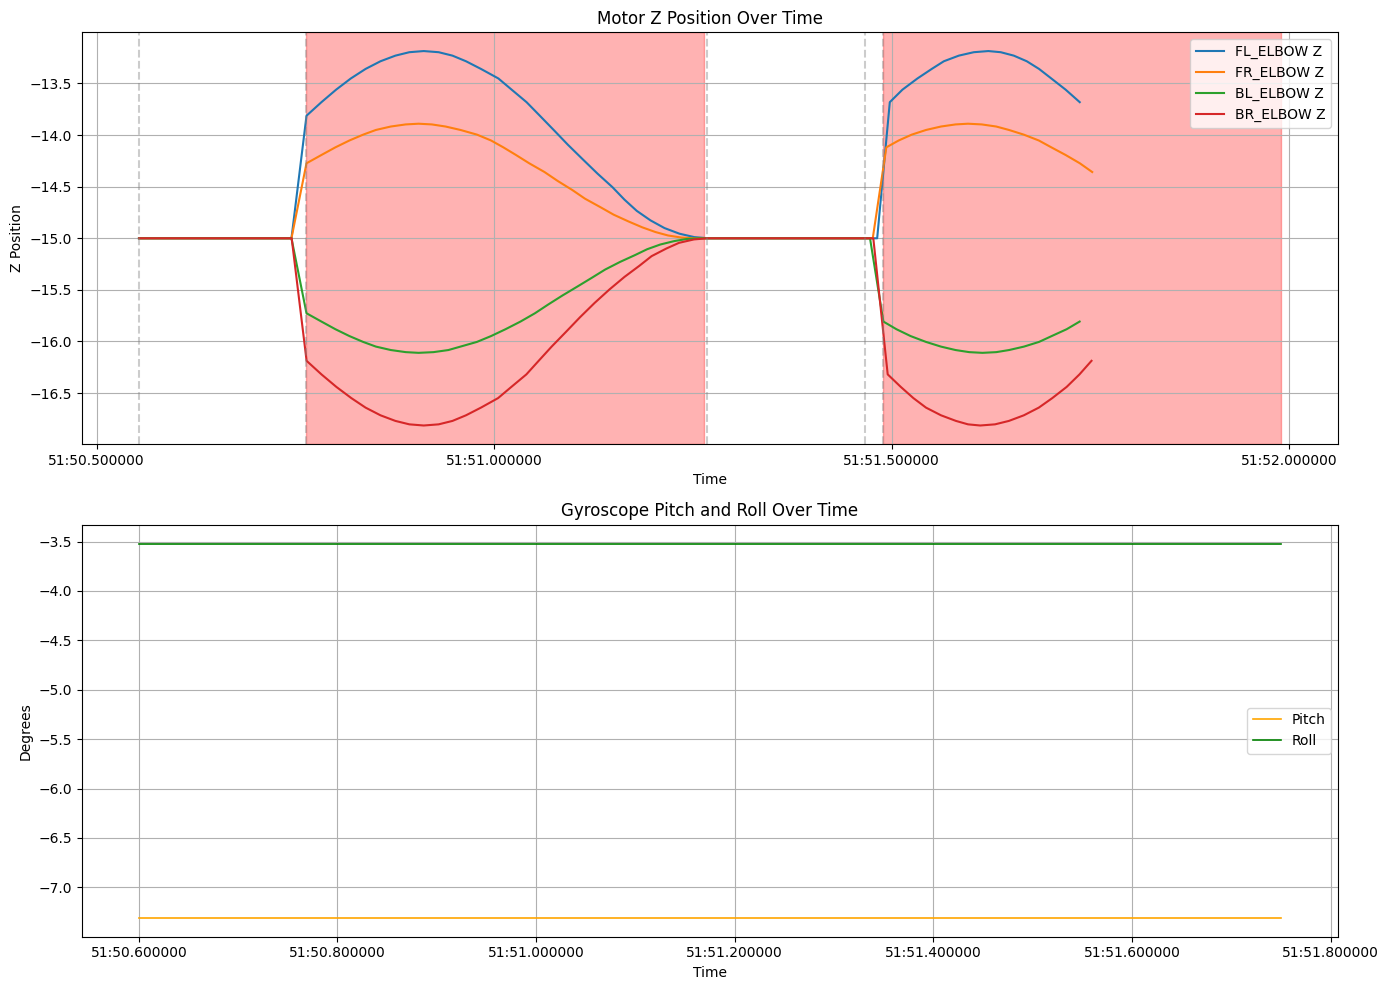

In [33]:
import time, threading, numpy as np, pandas as pd, matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import deque

# --- Constants ---
MOTOR_INTERVAL, GYRO_INTERVAL, SIM_DURATION, COMP_DURATION = 0.015, 0.01, 1.2, 0.5

@dataclass
class GyroData: roll: float; pitch: float; yaw: float
@dataclass
class MotorState: name: str; z_position: float

# --- Globals ---
motor_names = ["FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"]
log_data, latest_gyro = [], None
fsm_state, compensation_start_time, ramp_detected_time = "FLAT_IDLE", None, None
ready_to_compensate, saved_gyro = False, None

# --- FSM ---
def is_on_ramp(g: GyroData, p=2.0, r=2.0): return abs(g.pitch) > p or abs(g.roll) > r

def update_fsm_state(g):
    global fsm_state, compensation_start_time, ramp_detected_time, ready_to_compensate, saved_gyro
    now = time.time()
    if fsm_state == "ON_RAMP_COMPENSATING" and now - compensation_start_time > COMP_DURATION:
        fsm_state, ramp_detected_time, ready_to_compensate = "RECOVERY", None, False
    elif fsm_state == "RECOVERY" and now - compensation_start_time > COMP_DURATION + 0.2:
        fsm_state = "FLAT_IDLE"
    elif is_on_ramp(g):
        if not ramp_detected_time: ramp_detected_time = now
        elif now - ramp_detected_time >= 0.2 and not ready_to_compensate:
            fsm_state, compensation_start_time, saved_gyro, ready_to_compensate = "ON_RAMP_COMPENSATING", now, g, True
    else:
        fsm_state, ramp_detected_time, ready_to_compensate = "FLAT_IDLE", None, False

# --- Core Logic ---
def compute_compensation(m: MotorState, g: GyroData, t, pg=0.2, rg=0.1, sp=40):
    p = (t % sp) / sp
    gs = 0.5 * (1 - np.cos(2 * np.pi * p))
    pitch_adj, roll_adj = pg * g.pitch * gs, rg * g.roll * gs
    z = m.z_position
    if m.name.startswith("FL") or m.name.startswith("FR"): z -= pitch_adj
    if m.name.startswith("BL") or m.name.startswith("BR"): z += pitch_adj
    if m.name.startswith("FL") or m.name.startswith("BL"): z -= roll_adj
    if m.name.startswith("FR") or m.name.startswith("BR"): z += roll_adj
    return MotorState(m.name, z)

def send_to_motor(m: MotorState, ts, g: GyroData):
    log_data.append({"timestamp": ts, "motor_name": m.name, "z_position": m.z_position, "gyro_roll": g.roll, "gyro_pitch": g.pitch, "gyro_yaw": g.yaw, "fsm_state": fsm_state})

# --- Threads ---
def gyro_data_thread():
    global latest_gyro
    idx = 0
    while time.time() - start_time < SIM_DURATION and idx < len(gyro_data_samples):
        g = gyro_data_samples[idx]
        update_fsm_state(g)
        latest_gyro, idx = g, idx + 1
        time.sleep(GYRO_INTERVAL)

def motor_data_thread(name):
    t = 0
    while time.time() - start_time < SIM_DURATION:
        pos = MotorState(name, -15.0)
        g = saved_gyro if fsm_state == "ON_RAMP_COMPENSATING" else latest_gyro
        if g:
            send_to_motor(compute_compensation(pos, g, t) if fsm_state == "ON_RAMP_COMPENSATING" else pos, time.time(), g)
        t += 1
        time.sleep(MOTOR_INTERVAL)

# --- Gyro Samples ---
gyro_data_samples = [GyroData(-3.52, -7.31, -4.03 + i * 0.02) for i in range(60)] * 10

# --- Run ---
start_time = time.time()
threads = [threading.Thread(target=gyro_data_thread)] + [threading.Thread(target=motor_data_thread, args=(n,)) for n in motor_names]
for t in threads: t.start()
for t in threads: t.join()

# --- Plot ---
df = pd.DataFrame(log_data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
plt.figure(figsize=(14, 10))

# Z position plot
plt.subplot(2, 1, 1)
for n in motor_names:
    md = df[df['motor_name'] == n]
    plt.plot(md['timestamp'], md['z_position'], label=f"{n} Z", linewidth=1.5)
plt.title("Motor Z Position Over Time"); plt.xlabel("Time"); plt.ylabel("Z Position")
plt.legend(); plt.grid(True)

# FSM state shading and vertical state transition lines
fsm_changes = df[df['fsm_state'].shift() != df['fsm_state']]
for _, row in fsm_changes.iterrows():
    plt.axvline(row['timestamp'], linestyle='--', color='gray', alpha=0.4)

for _, g in df[df['fsm_state'] == 'ON_RAMP_COMPENSATING'].groupby((df['fsm_state'] != df['fsm_state'].shift()).cumsum()):
    if not g.empty:
        s, e = g['timestamp'].iloc[0], g['timestamp'].iloc[0] + pd.Timedelta(seconds=COMP_DURATION)
        plt.axvspan(s, e, color='red', alpha=0.3)

# Gyroscope data plot
plt.subplot(2, 1, 2)
gyro_df = df.drop_duplicates(subset='timestamp')[['timestamp', 'gyro_pitch', 'gyro_roll']].set_index('timestamp').resample('50ms').ffill().reset_index()
plt.plot(gyro_df['timestamp'], gyro_df['gyro_pitch'], label="Pitch", color='orange', linewidth=1.2)
plt.plot(gyro_df['timestamp'], gyro_df['gyro_roll'], label="Roll", color='green', linewidth=1.2)
plt.title("Gyroscope Pitch and Roll Over Time"); plt.xlabel("Time"); plt.ylabel("Degrees")
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

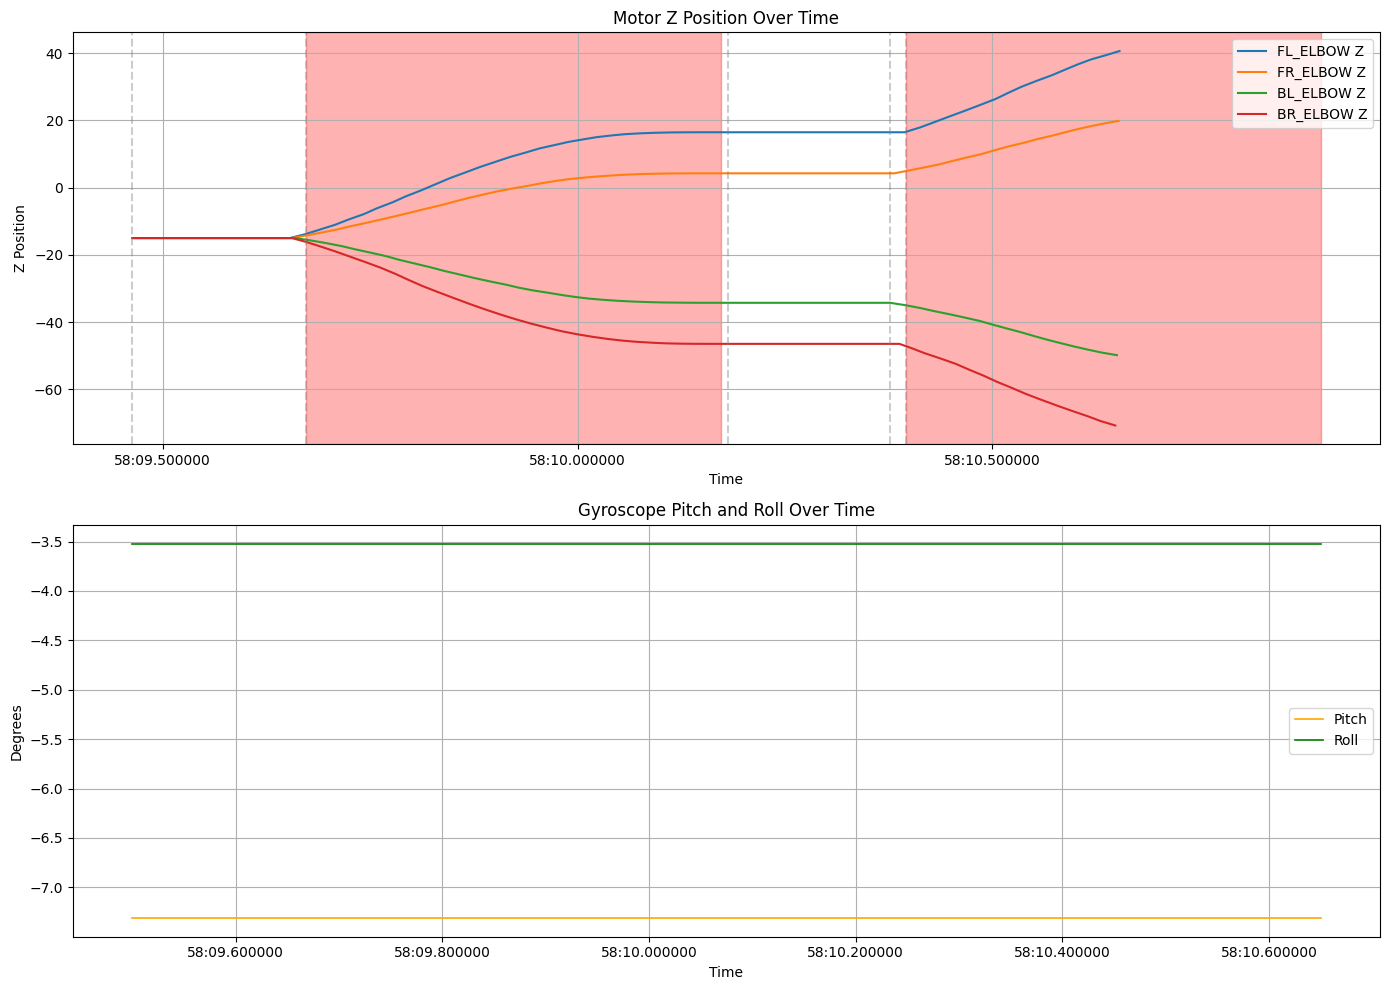

In [34]:
import time, threading, numpy as np, pandas as pd, matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import deque

# --- Constants ---
MOTOR_INTERVAL, GYRO_INTERVAL, SIM_DURATION, COMP_DURATION = 0.015, 0.01, 1.2, 0.5

@dataclass
class GyroData: roll: float; pitch: float; yaw: float
@dataclass
class MotorState: name: str; z_position: float

# --- Globals ---
motor_names = ["FL_ELBOW", "FR_ELBOW", "BL_ELBOW", "BR_ELBOW"]
log_data, latest_gyro = [], None
fsm_state, compensation_start_time, ramp_detected_time = "FLAT_IDLE", None, None
ready_to_compensate, saved_gyro = False, None
last_z_position = {name: -15.0 for name in motor_names}

# --- FSM ---
def is_on_ramp(g: GyroData, p=2.0, r=2.0): return abs(g.pitch) > p or abs(g.roll) > r

def update_fsm_state(g):
    global fsm_state, compensation_start_time, ramp_detected_time, ready_to_compensate, saved_gyro
    now = time.time()
    if fsm_state == "ON_RAMP_COMPENSATING" and now - compensation_start_time > COMP_DURATION:
        fsm_state, ramp_detected_time, ready_to_compensate = "RECOVERY", None, False
    elif fsm_state == "RECOVERY" and now - compensation_start_time > COMP_DURATION + 0.2:
        fsm_state = "FLAT_IDLE"
    elif is_on_ramp(g):
        if not ramp_detected_time: ramp_detected_time = now
        elif now - ramp_detected_time >= 0.2 and not ready_to_compensate:
            fsm_state, compensation_start_time, saved_gyro, ready_to_compensate = "ON_RAMP_COMPENSATING", now, g, True
    else:
        fsm_state, ramp_detected_time, ready_to_compensate = "FLAT_IDLE", None, False

# --- Core Logic ---
def compute_compensation(m: MotorState, g: GyroData, t, pg=0.2, rg=0.1, sp=40):
    p = (t % sp) / sp
    gs = 0.5 * (1 - np.cos(2 * np.pi * p))
    pitch_adj, roll_adj = pg * g.pitch * gs, rg * g.roll * gs
    z = m.z_position
    if m.name.startswith("FL") or m.name.startswith("FR"): z -= pitch_adj
    if m.name.startswith("BL") or m.name.startswith("BR"): z += pitch_adj
    if m.name.startswith("FL") or m.name.startswith("BL"): z -= roll_adj
    if m.name.startswith("FR") or m.name.startswith("BR"): z += roll_adj
    return MotorState(m.name, z)

def send_to_motor(m: MotorState, ts, g: GyroData):
    log_data.append({"timestamp": ts, "motor_name": m.name, "z_position": m.z_position, "gyro_roll": g.roll, "gyro_pitch": g.pitch, "gyro_yaw": g.yaw, "fsm_state": fsm_state})

# --- Threads ---
def gyro_data_thread():
    global latest_gyro
    idx = 0
    while time.time() - start_time < SIM_DURATION and idx < len(gyro_data_samples):
        g = gyro_data_samples[idx]
        update_fsm_state(g)
        latest_gyro, idx = g, idx + 1
        time.sleep(GYRO_INTERVAL)

def motor_data_thread(name):
    t = 0
    while time.time() - start_time < SIM_DURATION:
        base_z = last_z_position[name]
        pos = MotorState(name, base_z)
        g = saved_gyro if fsm_state == "ON_RAMP_COMPENSATING" else latest_gyro
        if g:
            if fsm_state == "ON_RAMP_COMPENSATING":
                compensated_motor = compute_compensation(pos, g, t)
                last_z_position[name] = compensated_motor.z_position  # retain adjusted z
                send_to_motor(compensated_motor, time.time(), g)
            else:
                send_to_motor(pos, time.time(), g)
        t += 1
        time.sleep(MOTOR_INTERVAL)

# --- Gyro Samples ---
gyro_data_samples = [GyroData(-3.52, -7.31, -4.03 + i * 0.02) for i in range(60)] * 10

# --- Run ---
start_time = time.time()
threads = [threading.Thread(target=gyro_data_thread)] + [threading.Thread(target=motor_data_thread, args=(n,)) for n in motor_names]
for t in threads: t.start()
for t in threads: t.join()

# --- Plot ---
df = pd.DataFrame(log_data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
plt.figure(figsize=(14, 10))

# Z position plot

plt.subplot(2, 1, 1)
for n in motor_names:
    md = df[df['motor_name'] == n]
    plt.plot(md['timestamp'], md['z_position'], label=f"{n} Z", linewidth=1.5)
plt.title("Motor Z Position Over Time"); plt.xlabel("Time"); plt.ylabel("Z Position")
plt.legend(); plt.grid(True)

# FSM state shading and vertical state transition lines
fsm_changes = df[df['fsm_state'].shift() != df['fsm_state']]
for _, row in fsm_changes.iterrows():
    plt.axvline(row['timestamp'], linestyle='--', color='gray', alpha=0.4)

for _, g in df[df['fsm_state'] == 'ON_RAMP_COMPENSATING'].groupby((df['fsm_state'] != df['fsm_state'].shift()).cumsum()):
    if not g.empty:
        s, e = g['timestamp'].iloc[0], g['timestamp'].iloc[0] + pd.Timedelta(seconds=COMP_DURATION)
        plt.axvspan(s, e, color='red', alpha=0.3)

# Gyroscope data plot
plt.subplot(2, 1, 2)
gyro_df = df.drop_duplicates(subset='timestamp')[['timestamp', 'gyro_pitch', 'gyro_roll']].set_index('timestamp').resample('50ms').ffill().reset_index()
plt.plot(gyro_df['timestamp'], gyro_df['gyro_pitch'], label="Pitch", color='orange', linewidth=1.2)
plt.plot(gyro_df['timestamp'], gyro_df['gyro_roll'], label="Roll", color='green', linewidth=1.2)
plt.title("Gyroscope Pitch and Roll Over Time"); plt.xlabel("Time"); plt.ylabel("Degrees")
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()
